## This notebook shows an example application of scGeno to explore imprinted gene expression in mouse embryos using publically available scRNA-seq data from Grosswendt et al. 2020

In [1]:
import scanpy as sc
sc.settings.verbosity = 0

import seaborn as sns
sns.set_theme()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('default')               # Reset to default style
plt.rcParams['axes.facecolor'] = 'white'   # White plot background
plt.rcParams['figure.facecolor'] = 'white' # White figure background
plt.rcParams['grid.alpha'] = 0  

In [10]:
import os
from pathlib import Path

aggr_dir = Path(os.getenv("AGGR_DIR", "./aggregated_data"))
data_dir = Path(os.getenv("DATA_DIR", "./data"))
output_dir = Path(os.getenv("OUTPUT_DIR", "./results"))

In [4]:
gtf_simple = pd.read_csv("../metadata/gencode.vM10.annotation.simple.csv", sep=',', names=['chr', '', 'start', 'end', 'type', 'Gene'])

In [5]:
pat_imp_genes = ["Ano1", "B830012L14Rik", "Cd81", "Cdkn1c", "Commd1", "Copg2", "Dhcr7",
    "H19", "Igf2r", "Kcnq1", "Klf14", "Mirg", "Phlda2", "Ppp1r9a", "Rian", 
    "Slc22a18", "Slc22a2", "Slc22a3", "Zim1" ]

mat_imp_genes = ["Dio3", "Dlk1", "Galnt6", "Igf2", "Kcnq1ot1", "Mage2", "Mcts2", 
    "Mkrn3", "Nap1l5", "Peg12", "Peg13", "Peg3", "Plagl1", "Slc38a4", 
    "Snrpn", "Usp29", "Zdbf2", "Zfp64", "Zrsr1"]

In [ ]:
# Read aggregated data
adata_aggr = sc.read_h5ad(aggr_dir / "wt_85_new.h5ad")

# Read G1 and G2 data
adata_G1 = sc.read_10x_h5(data_dir / "cr_aggr_WT85_G1/outs/count/filtered_feature_bc_matrix.h5")
adata_G2 = sc.read_10x_h5(data_dir / "cr_aggr_WT85_G2/outs/count/filtered_feature_bc_matrix.h5")

In [6]:
adata_aggr.var_names_make_unique()
adata_G1.var_names_make_unique()
adata_G2.var_names_make_unique()

if 'BC' in adata_aggr.obs.columns:
    adata_aggr.obs.set_index("BC", inplace=True)
    
adata_G1.obs = adata_G1.obs.merge(adata_aggr.obs, how='left', left_index=True, right_index=True)
adata_G2.obs = adata_G2.obs.merge(adata_aggr.obs, how='left', left_index=True, right_index=True)

sc.pp.normalize_total(adata_G1)
sc.pp.normalize_total(adata_G2)

In [ ]:
imp_genes = pat_imp_genes
genes_G1 = [gene for gene in imp_genes if gene in adata_G1.var_names]
genes_G2 = [gene for gene in imp_genes if gene in adata_G2.var_names]
genes = list(set(genes_G1).intersection(set(genes_G2)))

obs_df_G1 = sc.get.obs_df(adata_G1, keys=genes + ['embryo'])
obs_df_G1 = obs_df_G1.groupby('embryo')[genes].mean() # sum() or .mean()

obs_df_G2 = sc.get.obs_df(adata_G2, keys=genes + ['embryo'])
obs_df_G2 = obs_df_G2.groupby('embryo')[genes].mean() # sum() or .mean()

In [8]:
# Use expression level dependent pseudocounts
# Use small fraction of mean expression
mean_expr = np.mean(np.concatenate([obs_df_G1.values.flatten(), obs_df_G2.values.flatten()]))
pseudocount = mean_expr * 0.01  # 1% of mean expression

obs_df_G1 = obs_df_G1 + pseudocount
obs_df_G2 = obs_df_G2 + pseudocount

In [9]:
# make sure that embryos are in the same order in both dfs
# Align embryos before division
common_embryos = obs_df_G1.index.intersection(obs_df_G2.index)
obs_df_G1_aligned = obs_df_G1.loc[common_embryos]
obs_df_G2_aligned = obs_df_G2.loc[common_embryos]

In [10]:
obs_df = np.log2(obs_df_G1_aligned.div(obs_df_G2_aligned))
obs_df = obs_df.T

In [11]:
# Find imprinted genes coordinates (N.B. Imprinted genes are usually clustered)
imp_genes_coordinates = gtf_simple[gtf_simple['Gene'].isin(imp_genes)][['chr', 'start', 'end', 'Gene']]

In [12]:
imp_genes_coordinates

,chr,start,end,Gene
16264,chr6,4902917,5165661,Ppp1r9a
16587,chr6,30747554,30896794,Copg2
16590,chr6,30956023,30959078,Klf14
19557,chr7,6671269,6696450,Zim1
23986,chr7,142575529,142578143,H19
24003,chr7,143052739,143067934,Cd81
24006,chr7,143106362,143427042,Kcnq1
24020,chr7,143458339,143461050,Cdkn1c
24022,chr7,143473736,143499334,Slc22a18
24023,chr7,143501545,143503150,Phlda2


In [13]:
obs_df

embryo,embryo1,embryo2,embryo3,embryo4,embryo5,embryo6,embryo7,embryo8,embryo9,embryo10
Klf14,0.407159,0.000000,1.198210,1.198666,0.317095,0.811796,0.933627,0.251416,0.713011,1.214990
Kcnq1,1.396523,0.664664,2.086217,0.770141,0.582936,1.191856,0.686138,1.573453,0.869374,1.004808
B830012L14Rik,6.247832,5.908084,6.302711,5.140241,5.547690,5.455305,6.219473,5.538745,5.722280,5.998571
Dhcr7,2.230572,2.147440,1.952175,2.303869,0.040359,1.251222,1.657418,2.387858,0.270190,0.622857
Slc22a2,1.742616,1.297621,0.260516,1.505563,0.255234,1.421872,1.415521,1.082688,1.037192,0.745315
Zim1,3.676187,2.405380,2.939686,3.132296,3.421619,2.216561,3.682990,3.162902,2.607409,1.850637
Slc22a18,1.602963,1.126110,1.977123,2.249893,2.151930,1.692890,1.932158,1.808758,1.334504,2.095284
Mirg,4.706502,5.023303,5.539751,4.414706,5.254505,3.810898,4.950241,4.934327,5.112673,4.553465
Ano1,3.930474,4.137806,4.388529,2.601734,0.368975,0.414916,0.485258,4.026558,0.281821,1.125380
H19,7.500478,8.532477,3.759901,8.099253,4.810834,6.395677,3.440072,8.019343,5.417346,4.938126


In [ ]:
# For each gene check if it is in a mixed state, for each embryo
for embryo in obs_df.columns:
    print(embryo)
    for gene in imp_genes:
        seg_df = pd.read_csv(f"/home/tornisie/HMM_wt85/wt85_decoded_segments_{embryo}.bed", sep='\t', header=0)
        print(gene)
        chr = str(imp_genes_coordinates.loc[imp_genes_coordinates['Gene'] == gene, 'chr'].iloc[0])
        start = int(imp_genes_coordinates.loc[imp_genes_coordinates['Gene'] == gene, 'start'].iloc[0])
        end = int(imp_genes_coordinates.loc[imp_genes_coordinates['Gene'] == gene, 'end'].iloc[0])

        seg_df = seg_df[seg_df['chr'] == chr]

        for _, seg in seg_df.iterrows():
            if (end <= seg['end'] and start >= seg['start']):
                print(f"Found segment for {gene} in {embryo}: {seg['chr']}:{seg['start']}-{seg['end']} with state {seg['hidden_state']}")
                if seg['hidden_state'] == 1:
                    print(f"{gene} in {embryo} is in a homozygous B6/B6 state")
                    obs_df.at[gene, embryo] = np.nan
                else: print(f"{gene} in {embryo} is in a mixed state")

In [15]:
embryos = obs_df.columns.tolist()
obs_df = obs_df.T
obs_df.reset_index(inplace=True)

missing_embryos = obs_df.isna().sum().to_dict()
obs_df = pd.melt(obs_df, id_vars='embryo', var_name='Imprinted_Gene', value_name='Log2_FC')
avg_FC = obs_df.pivot(index='Imprinted_Gene', columns='embryo', values='Log2_FC').mean(axis=1).to_frame()
avg_FC = avg_FC.rename(columns={0:'avg_log2FC'}).reset_index()

missing_embryos = pd.DataFrame.from_dict(missing_embryos, orient='index', columns=['missing_embryos']).drop('embryo')
missing_embryos = missing_embryos.reset_index().rename(columns={'index':'Imprinted_Gene'})

avg_FC = pd.merge(avg_FC, missing_embryos)
avg_FC['embryos'] = len(embryos) - avg_FC['missing_embryos']
avg_FC['sample'] = "wt_85"

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'Ano1'),
  Text(1, 0, 'B830012L14Rik'),
  Text(2, 0, 'Cd81'),
  Text(3, 0, 'Cdkn1c'),
  Text(4, 0, 'Commd1'),
  Text(5, 0, 'Copg2'),
  Text(6, 0, 'Dhcr7'),
  Text(7, 0, 'H19'),
  Text(8, 0, 'Igf2r'),
  Text(9, 0, 'Kcnq1'),
  Text(10, 0, 'Klf14'),
  Text(11, 0, 'Mirg'),
  Text(12, 0, 'Phlda2'),
  Text(13, 0, 'Ppp1r9a'),
  Text(14, 0, 'Rian'),
  Text(15, 0, 'Slc22a18'),
  Text(16, 0, 'Slc22a2'),
  Text(17, 0, 'Slc22a3'),
  Text(18, 0, 'Zim1')])

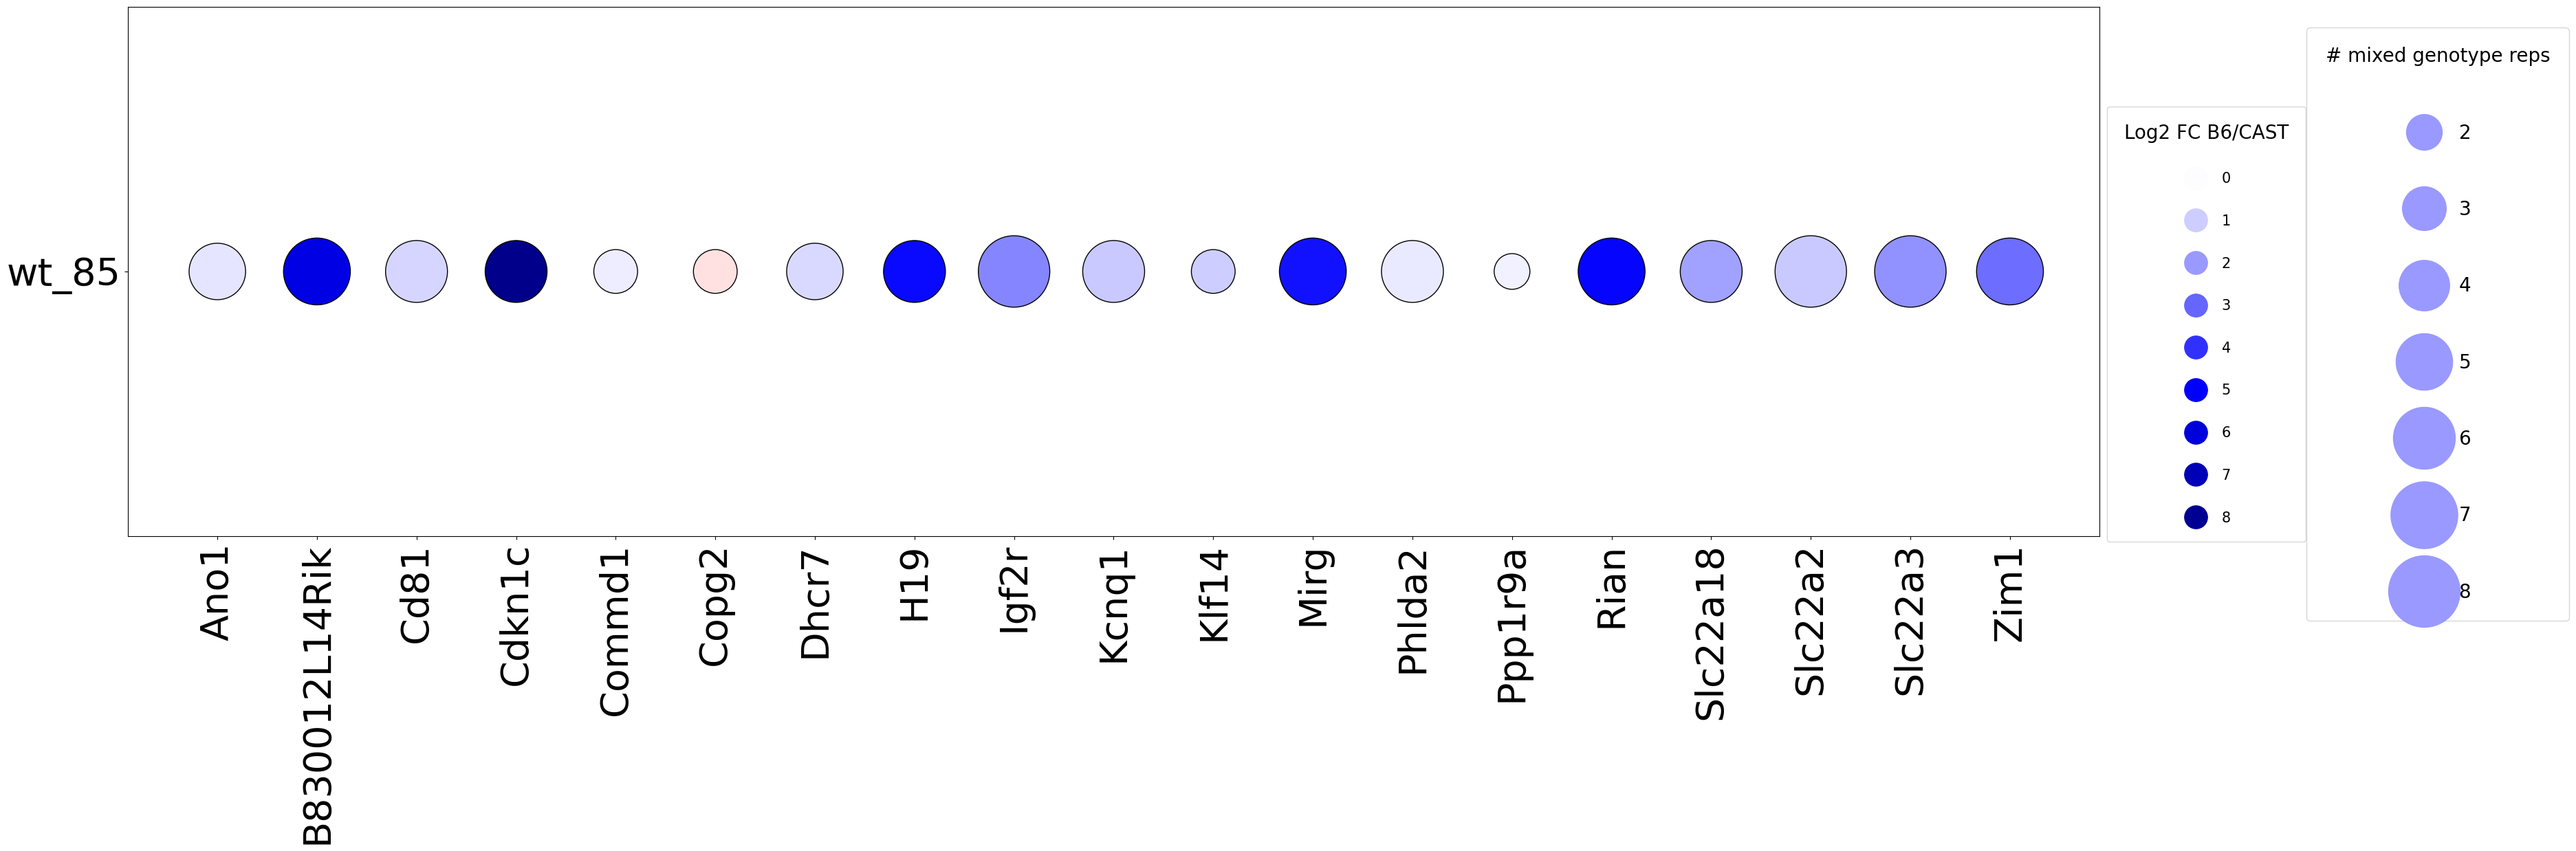

In [16]:
fig, ax = plt.subplots(figsize=(37, 10))

scatter = ax.scatter(
    avg_FC.Imprinted_Gene, avg_FC['sample'], s=(avg_FC.embryos)*700, c=avg_FC.avg_log2FC, 
    cmap="seismic_r", linewidth=1, edgecolors='black',  vmin=-10, vmax=10)
legend1 = ax.legend(*scatter.legend_elements(num=9), markerscale=4, loc='center left', 
                    title="Log2 FC B6/CAST", prop={'size': 15}, labelspacing=2, borderpad=1.2, bbox_to_anchor=(1, 0.4))
ax.add_artist(legend1)

kw = dict(prop="sizes", num=6, color=scatter.cmap(0.6), func=lambda s: s/700)
legend2 = ax.legend(*scatter.legend_elements(**kw), loc='center left', title="# mixed genotype reps", 
                    prop={'size': 20}, labelspacing=3, borderpad=1, bbox_to_anchor=(1.10, 0.4))
legend1.get_title().set_fontsize('20')
legend2.get_title().set_fontsize('20')
ax.tick_params(labelsize=40)
plt.xticks(rotation = 90)